# Introduction to Darts for Time Series Forecasting
<details>
<summary>License</summary>

<pre>
MIT License

Copyright (c) 2025 Zhihao Dai

Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.

</pre>

</details>
Author: Dr Zhihao Dai (Postdoctoral Researcher, Oxford)

<img src="https://github.com/unit8co/darts/raw/master/static/images/darts-logo-trim.png" alt="Darts Logo" width="50%"/>

This notebook demonstrates using [Darts](https://unit8co.github.io/darts/) for time series forecasting in Python. Specifically, we will:
1. Load an internal Oxford dataset on an energy meter.
2. Fill in missing values and visualize the data.
3. Split the data into training and validation sets.
4. Create and fit a forecasting model.
5. Make predictions and visualize the results.
6. Evaluate the model's performance.
7. (Optional) Improve the performance even further.


Let's get started!

# Installation

Create a conda environment using the provided `darts.yml` file:

```sh
conda env create -f darts.yml
conda activate forecasting
```

To answer the questions in this notebook, you might want to check the [Darts documentation](https://unit8co.github.io/darts/).

## Load Dataset
First, we will load the data in CSV format using `pandas` before converting it to a Darts `TimeSeries` object.
- In Darts, a `TimeSeries` object represents an univariate or multivariate time series with a time index.

#### TODO:
- By default, the index is read as strings.
- Before converting `DataFrame` to `TimeSeries`, we need to convert the index to datetime objects.


In [1]:
import pandas as pd

# Read the CSV file into a DataFrame
df = pd.read_csv("../Data/holywell_elec_2024.csv", index_col=0)
# Remove duplicate indices
df = df[~df.index.duplicated(keep='first')]
# TODO: Fill in the `format` argument based on the datetime format in the CSV file
df.index = pd.to_datetime(df.index, format='mixed').tz_localize(None)
# Truncate the last two weeks of data to remove holiday period
df = df[:-14 * 24]

assert df.index.dtype == "datetime64[ns]", "Index is not in datetime format"
df

,kWh
datetime_period_start,
2024-01-01 00:00:00,4.506
2024-01-01 01:00:00,4.382
2024-01-01 02:00:00,4.631
2024-01-01 03:00:00,4.462
2024-01-01 04:00:00,4.712
...,...
2024-12-17 19:00:00,5.180
2024-12-17 20:00:00,4.359
2024-12-17 21:00:00,4.104


## Convert to `TimeSeries`

Now that we have a `DataFrame` with a datetime index, we can convert it to a Darts `TimeSeries` object:


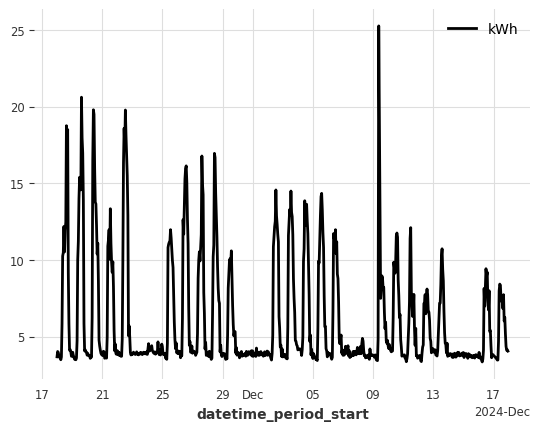

In [2]:
import numpy as np
from darts import TimeSeries

series = TimeSeries.from_dataframe(df).astype(np.float32)
# Plot the last 30 days of the time series
series[-24*30:].plot()

# Check for ANY missing values
assert not np.any(np.isnan(series.values())), "The time series contains missing values."

## Split Data into Training and Validation Sets
To evaluate the forecasting model, we need to split the data into training and validation sets. 
- Because this is time series data, we would typically use the earlier portion of the data for training and the later portion for validation.
- We will only use the training set to fit the model, and then we will evaluate the performance on the validation set.

#### TODO:
1. Split the `series` into `train_series` and `val_series`.
    - Use the `split_before` method to split the series at a specific timestamp.
    - We will use the last 24 hours of data for validation.


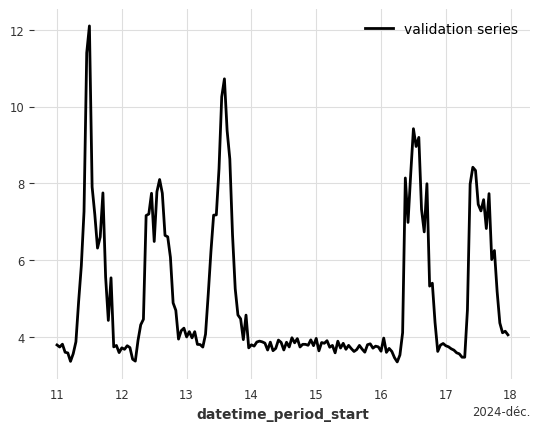

In [7]:
# TODO: fill in the code to split `series` into `train_series` and `val_series`
train_series, val_series = series.split_before(len(series) - 24*7)
val_series.plot(label="validation series")
assert len(val_series) == 24 * 7, "Validation series does not have 24 * 7 data points"

#### TODO:
2. Scale the training and validation series using `Scaler` from Darts.
   - For deep learning models, scaling the data can improve training stability and performance.
   - We will use `Scaler` to standardise the data (using `MinMaxScaler`) to the range [0, 1].


In [9]:
from darts.dataprocessing.transformers import Scaler

# TODO: create a `Scaler` object here
scaler = Scaler()
# TODO: fit the scaler on `train_series` and transform it to `train_series_scaled`
train_series_scaled = scaler.fit(train_series).transform(train_series)
# TODO: transform `val_series` to `val_series_scaled` using the fitted scaler 
# so we can evaluate on the scaled data
val_series_scaled = scaler.transform(val_series)

## Create and Fit a Forecasting Model
Now on to the exciting part of forecasting!
- We will create a `RNNModel` from Darts and fit it to the training data.
- For documentation on `RNNModel`, see [here](https://unit8co.github.io/darts/generated_api/darts.models.forecasting.rnn_model.html#darts.models.forecasting.rnn_model.RNNModel).

#### TODO:
1. Create an `LSTM` model with an input chunk length of 24 hours.
2. Fit the model to `train_series` for 10 epochs.


In [10]:
from darts.models import RNNModel

# TODO: create an LSTM model with an input chunk length of 24 hours.
model = RNNModel(input_chunk_length = 24
)
model.fit(train_series_scaled, verbose=True, epochs=10)

The StatsForecast module could not be imported. To enable support for the AutoARIMA, AutoETS and Croston models, please consider installing it.
The `XGBoost` module could not be imported. To enable XGBoost support in Darts, follow the detailed instructions in the installation guide: https://github.com/unit8co/darts/blob/master/INSTALL.md
The `XGBoost` module could not be imported. To enable XGBoost support in Darts, follow the detailed instructions in the installation guide: https://github.com/unit8co/darts/blob/master/INSTALL.md
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_me

Epoch 9: 100%|██████████| 258/258 [00:02<00:00, 104.16it/s, train_loss=0.00256] 

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 258/258 [00:02<00:00, 104.00it/s, train_loss=0.00256]


RNNModel(model=RNN, hidden_dim=25, n_rnn_layers=1, dropout=0.0, training_length=24, input_chunk_length=24)

#### TODO:
3. Make predictions with the trained model for the next 7 days (24 * 7 hours).
4. Inverse transform the predictions to the original scale.


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
c:\Users\hecto\miniconda3\envs\GeoPower\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 20.83it/s]


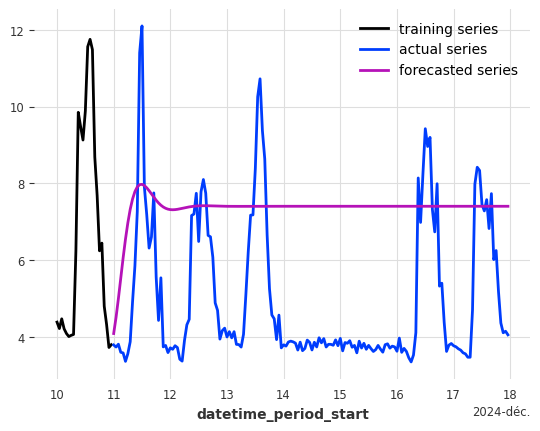

In [13]:
# TODO: Make predictions with the trained model
pred = model.predict(7*24)
# TODO: Inverse transform the predictions to the original scale
pred_unscaled = scaler.inverse_transform(pred)

# Plot the results
train_series[-24:].plot(label="training series")
val_series.plot(label="actual series")
pred_unscaled.plot(label="forecasted series");

## Evaluate the Model (Hard)
Finally, we will evaluate the model's performance on the validation set.
We would simulate a real-world use case where we make rolling forecasts over the validation period.
Specifically, we will make a day-ahead forecast at the start of each day in the validation set.

This is also called **backtesting** or **historical forecasting** in literature.

#### TODO:
1. Use `model.historical_forecasts` to make rolling forecasts over the validation period.
    - Set `start` to the start time of the validation series.
    - Set `forecast_horizon` to the correct value for day-ahead forecasts.
    - Set `stride` to the correct value to make forecasts every day.
    - Set `retrain` to `False` to avoid retraining the model at each step.
    - Use the scaled **whole** series for historical forecasts (Why?).


In [37]:
# TODO: Perform historical forecasts on the validation set
#val_start = series.time_index[-24*7]
#start_for_hist = val_start - series.freq # one step before validation
historical_forecasts_unscaled = model.historical_forecasts(
    series, start = val_series.start_time(), forecast_horizon = 24, stride = 24, retrain = False, last_points_only=False
)
historical_forecasts = [scaler.inverse_transform(forecast) for forecast in historical_forecasts_unscaled]
assert len(historical_forecasts) == 7, "There should be 7 historical forecasts, one for each day in the validation set."
assert historical_forecasts[0].start_time() == val_series_scaled.start_time(), "The first historical forecast should start at the beginning of the validation set."
assert all(len(forecast) == 24 for forecast in historical_forecasts), "Each historical forecast should have a length of 24."

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
c:\Users\hecto\miniconda3\envs\GeoPower\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


In [39]:
val_series_scaled.start_time()

Timestamp('2024-12-11 00:00:00')

For accuracy measurement, we will use **Mean Absolute Error (MAE)**, defined as the average absolute difference between the predicted and actual values.

#### TODO:
1. Measure the Mean Absolute Error (MAE) on the validation set.
    - Refer to the Darts documentation [metrics](https://unit8co.github.io/darts/generated_api/darts.metrics.html) for available metrics.


In [8]:
# TODO: Measure the Mean Absolute Error (MAE) on the validation set

mae_value = ...
print(f"Mean Absolute Error on validation set: {mae_value:.4f}")

Mean Absolute Error on validation set: 1.6584


## Improve the Model (Optional)
Now that we have a basic forecasting model, we can try to improve it further.
- Experiment with different [hyperparameters](https://unit8co.github.io/darts/generated_api/darts.models.forecasting.rnn_model.html#darts.models.forecasting.rnn_model.RNNModel) (e.g., learning rate, number of layers, hidden units) to see their impact on performance.
- Experiment with different data preprocessing techniques (e.g., [seasonal decomposition](https://unit8co.github.io/darts/generated_api/darts.utils.statistics.html?highlight=decompose#darts.utils.statistics.extract_trend_and_seasonality), [scaling methods](https://unit8co.github.io/darts/generated_api/darts.dataprocessing.transformers.scaler.html)) to see how they affect the model's accuracy.
- Consider [different model architectures](https://unit8co.github.io/darts/generated_api/darts.models.forecasting.html) (e.g., XGBoost, TFT, Dlinear) and understand their suitability to the data.
- Incorporate [covariates](https://unit8co.github.io/darts/quickstart/00-quickstart.html#Encoders:-using-covariates-for-free) (past or future such as time of day, holidays) to see if they improve forecasting performance.
- Use [`optuna`](https://unit8co.github.io/darts/examples/17-hyperparameter-optimization.html#Using-Optuna) for hyperparameter tuning to systematically search for the best model configuration.
- Use [ensemble methods](https://unit8co.github.io/darts/examples/19-EnsembleModel-examples.html) to combine predictions from multiple models for potentially better accuracy.
- Advanced techniques such as learning rate scheduling, early stopping, and optimisers can be applied to deep learning models to enhance training. You could learn more at [Torch Forecasting Models](https://unit8co.github.io/darts/userguide/torch_forecasting_models.html) and the training backend [PyTorch Lightning Trainer](https://lightning.ai/docs/pytorch/stable/common/trainer.html).

## Open-Source Contributions
If you enjoy using Darts and find it helpful for your projects, please consider contributing to the open-source community!
- Report any bugs or issues you have to the [Darts GitHub repository](https://github.com/unit8co/darts)
- Submit pull requests with bug fixes or new features to help improve Darts for everyone.
